In [104]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pylab as plt
from numpy import linalg as la
from scipy.optimize import fsolve
from scipy import linalg as scpla

In [106]:
# nonlinear transfer function -- we use tanh
def nonlineartransfer(x,params,type='tanh'):
    if type=='relu':
        a,theta = params[0],params[1]
        if x-theta>0:
            return a*(x-theta)
        else:
            return 0
    elif type=='tanh':
        return (1.0+np.tanh(x))/2.0

# run iterative loops, each one has a set of parameters
def run_dynamics(x0, stm, Net_settings,Conn_mat):
    tf_type = Net_settings['transfer_func']
    JE,JI   = Conn_mat['JE'],Conn_mat['JI']
    tfinal  = Net_settings['final_time']
    dt      = Net_settings['time_step']
    taxis = np.arange(0,tfinal,dt)
    nnum,nt = len(x0),len(taxis)
    x_seq = np.zeros((nnum,nt))
    x_dot_seq = np.zeros_like(x_seq)
    x_seq[:,0] = x0[:,0]
    for idxt in range(1,nt):
        for idx in range(nnum):
            x_dot = -x_seq[idx,idxt-1]+JE*nonlineartransfer(x_seq[0,idxt-1],0,)-JI*nonlineartransfer(x_seq[1,idxt-1],0,)+stm[idx]
            x_seq[idx,idxt]=x_dot*dt+x_seq[idx,idxt-1]
            x_dot_seq[idx,idxt-1] = x_dot

    return taxis,x_seq,x_dot_seq

# theoretical solution, finding roots 
def func_kappa(x,params):
    JE,JI,I1,I2,I_overlap,m=params[0],params[1],params[2],params[3],params[4],params[5]  
    return -x+(JE-JI)/2.0+(JE*np.tanh(x+I1)-JI*np.tanh(x+I2))/2.0+I_overlap

# r.h.s. function g(\kappa)
def rhsg_kappa(x,params):
    JE,JI,I1,I2,I_overlap,m = params[0],params[1],params[2],params[3],params[4],params[5]
    return JE*(1+np.tanh(x+I1))/2.0-JI*(1+np.tanh(x+I2))/2.0+I_overlap
# decompose the input signal I_{ext} -- component parallel to m and perpendicular to m
def decompinput(Iorg,m,):
  I1,I2=Iorg[0,0],Iorg[1,0]
  # overlapping
  innermul = I1*m[0,0]+I2*m[1,0]
  amp_m = 1.0/np.sqrt(np.sum(m**2))
  amp_I2m = innermul/np.sqrt(np.sum(m**2))
  I_overlap=amp_I2M*amp_m
  I_proj = amp_I2m*amp_m*m
  I_perpen = Iorg-I_proj
  
  return I_overlap,I_proj,I_perpen

# derivative np.tanh
def deriv_tanh(x):
  return (1-np.tanh(x)**2)/2.0

def deriv2_tanh(x):
  return -np.tanh(x)*(np.sech(x)**2)
# first order derivative of transfer function \phi
def transfer_derivmat(x,params,order=1):
    x0,x1=x.tolist()
    JE,JI=params[0],params[1]
    deriv_mat,deriv_mat2 = np.zeros((2,2)),np.zeros((2,2))
    deriv_mat[0,0] = JE*deriv_tanh(x0) #e2e
    deriv_mat[0,1] = -JI*deriv_tanh(x1) #i2e
    deriv_mat[1,0] = JE*deriv_tanh(x0) #e2i
    deriv_mat[1,1] = -JI*deriv_tanh(x1) #i2i
    return deriv_mat,[deriv_tanh(x0),deriv_tanh(x1)]

# figure out the critical points, which meet the requirement -- f(x) is tangent to g(x)
def solvetangent(x,params):
    x0,x1=x.tolist()
    JE,JI,I1,I2=params[0],params[1],params[2],params[3]
    C=(JE-JI)/2.0
    return [-x0+JE*(1+np.tanh(x0+I1))/2.0-JI*(1+np.tanh(x0+I2))/2.0+x1,-1+JE*(1-(np.tanh(x0+I1))**2)/2.0-JI*(1-(np.tanh(x0+I2))**2)/2.0]

In [108]:
# Network settings
Net_settings ={'transfer_func': 'tanh',
                'time_step': 0.1,
                'final_time':150,
}
# connectivity matrix
Conn_mat ={'JE': 1.4,
            'JI':1.2,
}
m = np.ones((2,1))
ntt = int(Net_settings['final_time']/Net_settings['time_step'])

In [110]:
JE,JI = Conn_mat['JE'],Conn_mat['JI']
tf, dt = Net_settings['final_time'],Net_settings['time_step']
tt = np.arange(0.0,Net_settings['final_time'],Net_settings['time_step'])

# choose 3 typical points to do numerical simulation
Iamp_typical = np.array([0.075,0.15,0.225])
nparam_Iamp = len(Iamp_typical)
kappa_num_series_up,kappa_num_series_bot = np.zeros((nparam_Iamp,ntt)),np.zeros((nparam_Iamp,ntt))
x_dot_series_up,x_dot_series_bot = np.zeros((nparam_Iamp,2,ntt)),np.zeros((nparam_Iamp,2,ntt))
x_series_up,x_series_bot = np.zeros((nparam_Iamp,2,ntt)),np.zeros((nparam_Iamp,2,ntt))
eps = 0.1
for idxi in np.arange(nparam_Iamp):
    C= (JE-JI)/2.0
    stm = Iamp_typical[idxi]
    # upper approximate
    x0 = stm*np.ones((2,1))
    x0[1,0]=0
    taxis, x_seq,x_dot_seq = run_dynamics(x0, np.zeros((2,1)), Net_settings,Conn_mat)
    x_series_up[idxi,:,:], x_dot_series_up[idxi,:,:] = x_seq, x_dot_seq
    kappa_num_series_up[idxi,:] = x_series_up[idxi,0,:]#-stm[0,0]

FP of x: [[0.11106062]
 [0.11106062]]


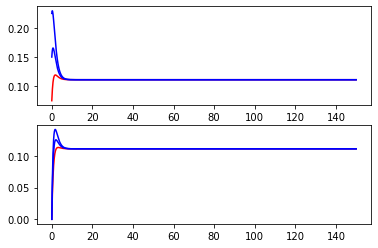

In [112]:
# plt.figure()
# plt.plot(tt,kappa_num_series_up[0,:],'r',label=r"$I_{amp}=-3.0$ upper")
# plt.plot(tt,kappa_num_series_up[1,:],'g',label=r"$I_{amp}=-2.5$ upper")
# plt.plot(tt,kappa_num_series_up[2,:],'b',label=r"$I_{amp}=-2.0$ upper")
plt.figure()
plt.subplot(2,1,1)
plt.plot(tt,x_series_up[0,0,:],'r',label=r"$J_E=0.5$ upper")
plt.plot(tt,x_series_up[1,0,:],'b',label=r"$J_E=3.0$ upper")
plt.plot(tt,x_series_up[2,0,:],'b',label=r"$J_E=5.0$ upper")
plt.subplot(2,1,2)
plt.plot(tt,x_series_up[0,1,:],'r',label=r"$J_E=0.5$ upper")
plt.plot(tt,x_series_up[1,1,:],'b',label=r"$J_E=3.0$ upper")
plt.plot(tt,x_series_up[2,1,:],'b',label=r"$J_E=5.0$ upper")

x_FP = np.reshape(np.squeeze(x_series_up[0,:,-1]),(2,1))
print('FP of x: ',x_FP)
kappa_FP,nu_FP = x_FP[0,0]/1.0,0.0

In [114]:
deriv_phi,pure_der = transfer_derivmat(x_FP,[JE,JI])
print('deriv_matrix: ',deriv_phi)
print('pure_deriv_phi, E: ',pure_der[0],'; I: ',pure_der[1])

deriv_matrix:  [[ 0.69143638 -0.59265976]
 [ 0.69143638 -0.59265976]]
pure_deriv_phi, E:  [0.49388313] ; I:  [0.49388313]


In [116]:
# calculate eigenvalue
lambdaJ,vJ = la.eig(deriv_phi)
print('eigenvalues: ',lambdaJ)

eigenvalues:  [9.87766259e-02 2.22044605e-16]


Previously, we use the original connectivity matrix to describe the network dynamics, the observations indicate a transient fluctuation before neuron finally settles down. However, non-zero eigenvalue of the system is negative, which intuitively suggests a temporally stable dynamics. Considering the simulating observations and the property of network with negative eigenvalue, we conclude that, for asymmetric network connectivity, eigenvalues/vectors can not fully account for the properties of the neuronal activity. Asymmetric connectivity matrix can not be diagnalized, but can be reduced to up-triangle matrix using QR decomposition or so. Here we consider generating a orthonormal basis vectors by using SVD.

In [118]:
# using SVD to find left(u) and right(v) singular vectors and singular values
u,sig,vh=la.svd(deriv_phi)
m = u.copy()
for i in range(2):
  m[:,i] = m[:,i]*sig[i] # m absorbs the singular values, thus we can use m@n to alternatively represents connectivity matrix
n = vh.T
deriv_phi_est = m@n.T
print('original conn: ',deriv_phi)
print('reconstructed conn(using SVD): ',deriv_phi_est)


original conn:  [[ 0.69143638 -0.59265976]
 [ 0.69143638 -0.59265976]]
reconstructed conn(using SVD):  [[ 0.69143638 -0.59265976]
 [ 0.69143638 -0.59265976]]


Intuitively, eigen-decomposition generates a diagonal matrix thus find an invariant direction, which means $Av=\lambda v$; SVD however, can transfer (rotate and stretch) one vector to another, which means $Av=\sigma u$.  
The eigenvectors of asymmetric matrix are not orthogonal, we then use SVD and corresponding left/right singular vectors, to constitute the orthogonal basis vectors needed and analyze the temporal dynamics. 

In [120]:
# singular value decomposition -- for deriv_phi
u,sig,vh = la.svd(deriv_phi)
m = u.copy()
for i in range(len(sig)):
    m[:,i]=m[:,i]*sig[i]
n = vh.T
print(m,n)
# previously, we have x0, now we use \kappa0(m)and v0(I)
# Iamp_typical = np.array([0.075,0.150,0.225])
kappa_typical = Iamp_typical.copy()
kappa_typical = kappa_typical/2.0-kappa_FP
nu_typical = Iamp_typical.copy()/2.0

num_typical,nt = len(kappa_typical),len(tt)

kappa_series,nu_series = np.zeros((num_typical,ntt)),np.zeros((num_typical,ntt))
x_series_ortho = np.zeros((num_typical,2,ntt))
m,I = np.array([[1,1]]).T,np.array([[1,-1]]).T
n = -n[:,0]
for i in range(num_typical):
    kappa_series[i,0] = kappa_typical[i]
    nu_series[i,0] = nu_typical[i]
    print((kappa_series[i,0]+kappa_FP)*m+nu_series[i,0]*I)
    for it in range(1,nt):
        delta_kappa = -kappa_series[i,it-1] + n.T@(kappa_series[i,it-1]*m+nu_series[i,it-1]*I)
        delta_kappa *=dt
        kappa_series[i,it] =kappa_series[i,it-1]+delta_kappa
        delta_nu = -nu_series[i,it-1]        
        delta_nu *=dt
        nu_series[i,it] =nu_series[i,it-1]+delta_nu
        x_series_ortho[i,:,it] = np.squeeze((kappa_series[i,it]+kappa_FP)*m+(nu_series[i,it]+nu_FP)*I)



[[-9.10675494e-01 -2.22158750e-17]
 [-9.10675494e-01  2.22158750e-17]] [[-0.7592566  -0.65079137]
 [ 0.65079137 -0.7592566 ]]
[[ 7.5000000e-02]
 [-6.9388939e-18]]
[[0.15]
 [0.  ]]
[[0.225]
 [0.   ]]


0.11106062414850597


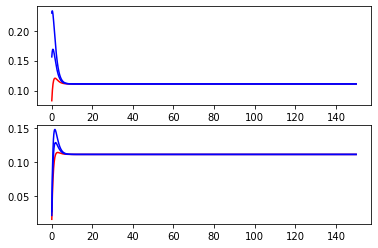

In [122]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(tt[1:],x_series_ortho[0,0,1:],'r',label=r"$J_E=0.5$ upper")
plt.plot(tt[1:],x_series_ortho[1,0,1:],'b',label=r"$J_E=3.0$ upper")
plt.plot(tt[1:],x_series_ortho[2,0,1:],'b',label=r"$J_E=5.0$ upper")
plt.subplot(2,1,2)
plt.plot(tt[1:],x_series_ortho[0,1,1:],'r',label=r"$J_E=0.5$ upper")
plt.plot(tt[1:],x_series_ortho[1,1,1:],'b',label=r"$J_E=3.0$ upper")
plt.plot(tt[1:],x_series_ortho[2,1,1:],'b',label=r"$J_E=5.0$ upper")
print(x_series_ortho[1,1,-1])

The numerical simulation showed that converting variables to a new, orthogonal coordinate can still accurately capture the network dynamics. The detailed mathematical analysis is as follows

We use left singular vectors, columns of $2 \times 2$ matrix $u$, as a new set of basis vectors $\mathbf{m}=[ 1,1] .\mathrm{T},\ \mathbf{I}=[ 1,-1].\mathrm{T}$. Then we can express the neuron activity vector $\mathbf{r}$ as the linear combination of this set of basis vectors $$ \mathbf{r}(t)=\kappa(t)\mathbf{m}+\nu(t)\mathbf{I}.$$
Also, the dynamics can be expressed as $$\frac{\mathrm{d}(\kappa(t)\mathbf{m}+\nu(t)\mathbf{I})}{\mathrm{d}t}=-(\kappa(t)\mathbf{m}+\nu(t)\mathbf{I})+J_{mat}\phi(\mathbf{r})+\mathbf{r}_0\delta t,$$ because of the orthogonality, we dissect coefficient for $\mathbf{m}$ and $\mathbf{I}$ apart $$\frac{\mathrm{d}}{\mathrm{d}t}\kappa(t)=-\kappa(t)+\mathbf{n}^{\intercal}\phi(\kappa(t)\mathbf{m}+\nu(t)\mathbf{I})+\kappa_0\delta (t),$$
$$\frac{\mathrm{d}}{\mathrm{d}t}\nu(t)=-\nu(t)+\nu_0\delta (t).$$
Previously, we figured out the Fixed Points of neuronal activity, the nonlinear transfer function can be linearized up to $\mathcal{O}(\kappa(t)\mathbf{m}+\nu(t)\mathbf{I})$ near the stable FP, and the dynamics of variable $\kappa(t)$ becomes
$$\frac{\mathrm{d}}{\mathrm{d}t}(\delta\kappa+\kappa^*)=-(\delta\kappa+\kappa^*)+\mathbf{n}^{\intercal}(\phi^*+(\phi^*)'(\delta\kappa\mathbf{m}+\delta\nu\mathbf{I}))+\delta\kappa_0\delta (t_{perturb}),$$
the fixed point satisfies $0=-\kappa^*+\mathbf{n}^{\intercal}\phi^*$ and $nu^*=0$, so we have
$$\frac{\mathrm{d}}{\mathrm{d}t}\delta\kappa=-\delta\kappa+\mathbf{n}^{\intercal}(\phi^*)'(\delta\kappa\mathbf{m}+\delta\nu\mathbf{I})+\delta\kappa_0\delta (t_{perturb}),$$
and
$$\frac{\mathrm{d}}{\mathrm{d}t}\delta\nu(t)=-\delta\nu(t)+\delta\nu_0\delta (t_{perturb}).$$
  
  We set $\mathbf{x}(t)=[\delta\kappa(t),\delta\nu(t)]^{\intercal}$, new connectivity matrix under orthogonal coordinate is  
\begin{equation}
\left[                  
\begin{array}{ccc}
 -1+J_E(\phi^*_E)'-J_I(\phi^*_I)'& J_E(\phi^*_E)'+J_I(\phi^*_I)'\\ 
 0& -1
\end{array}
\right ].
\end{equation}
The new matrix is reduced to an up-triangle format, diagonal elements represents self-compressing/stretching while off-diagonal elements indicate the embedded feedforward structure. From another point of view, the upper right element reflects the projection from external perturbation to recurrent space, thus indicates the structure of external perturbation and the overlap between recurrent and external stimulus can impact the diverging/converging of the neuronal activity.

In [124]:
def eigval_sym(Jmat,param_asym):
  # asymmetric components in E and I
  aE,aI = param_asym[0],param_asym[1]
  Jmat_asym=Jmat.copy()
  Jmat_asym[1,0]+=aE 
  Jmat_asym[1,1]+=aI 
  # generate symmetric matrix
  Jmat_sym = (Jmat_asym+Jmat_asym.T)/2.0
  # calculate Trace and Dominant
  trace_sym,det_sym=Jmat_sym.trace(),la.det(Jmat_sym)
  print('det num(num):',det_sym)
  eigval_sym,eigvec_sym=la.eig(Jmat_sym)

  return eigval_sym,trace_sym,det_sym

def partial_asym(Jmat,param_asym):
  # symmetric components in E and I
  Jmat_asym=Jmat.copy()
  JE,JI = Jmat_asym[0,0],-Jmat_asym[0,1]
  # asymmetric components in E and I
  aE,aI = param_asym[0],param_asym[1]
  
  Jmat_asym[1,0]+=aE 
  Jmat_asym[1,1]+=aI 
  # generate symmetric matrix
  Jmat_sym = (Jmat_asym+Jmat_asym.T)/2.0  
  # calculate Trace and Dominant
  trace_sym,det_sym=Jmat_sym.trace(),la.det(Jmat_sym)
  theo_det = Jmat_sym[0,0]*Jmat_sym[1,1]- Jmat_sym[0,1]*Jmat_sym[1,0]
  print('theo det: ',theo_det,'; num:',det_sym)
  # calculate partial_lambda_partial_a
  part_a = (JE+aE-JI)/np.sqrt(trace_sym**2-4*det_sym)/2.0
  part_b = (1+(-JE-JI+aI)/np.sqrt(trace_sym**2-4*det_sym))/2.0

  return part_a, part_b

In [126]:
Jmat=np.zeros((2,2))
Jmat[:,0],Jmat[:,1]=JE,-JI
a,b,eps=0.56,0.87,1e-3
numeigv,numtr,numdet=eigval_sym(Jmat,[a,b])
numeigv_,_,_=eigval_sym(Jmat,[a+eps,b])
numpart_a=(numeigv_[0]-numeigv[0])/eps
theo_a,theo_b=partial_asym(Jmat,[a,b])

print('numerical result: ',numpart_a,'; theoretical result: ',theo_a)

det num(num): -0.6683999999999999
det num(num): -0.6685802499999999
theo det:  -0.6683999999999999 ; num: -0.6683999999999999
numerical result:  0.10199972054003581 ; theoretical result:  0.10186413029537272


In [127]:
A=np.zeros((2,2))
A[:,0],A[:,1]=1.2,-1.4
U,S,VH=la.svd(A)

sigS= np.eye(2)*S
print('s',sigS)
matexp = scpla.expm(A*0.5)
print('matexp: ',matexp)
print('eleexp: ',scpla.expm(U@(sigS*0.5)@VH))
print('eleexp: ',np.exp((U@sigS@VH*0.5)))

s [[2.60768096e+00 0.00000000e+00]
 [0.00000000e+00 9.29025163e-17]]
matexp:  [[ 1.57097549 -0.66613807]
 [ 0.57097549  0.33386193]]
eleexp:  [[ 1.57097549 -0.66613807]
 [ 0.57097549  0.33386193]]
eleexp:  [[1.8221188 0.4965853]
 [1.8221188 0.4965853]]


Use SVD for Generalized connectivity matrix, compare the solutions

In [128]:
# give JE and JI, differences a and b --> JE+,JI+
JE,JI,a,b=1.2,1.4,0.1,0.2
Jmat = np.zeros((2,2))
Jmat[:,0],Jmat[:,1]=JE,-JI
Jmat[1,0]+=a
Jmat[1,1]-=b
JEP,JIP=JE+a,JI+b

u,s,vh = la.svd(Jmat)
# analytical solution 
tr=np.sum(np.sum(Jmat**2,axis=0))
det=(JE*JIP-JI*JEP)**2
lambdaJ=np.zeros(2)
lambdaJ[0],lambdaJ[1]=(tr+np.sqrt(tr**2-4*det))/2,(tr-np.sqrt(tr**2-4*det))/2
sigJ=np.sqrt(lambdaJ)
print('singular eigenvalue, package: ',s,'; analytical: ',sigJ)


singular eigenvalue, package:  [2.76562698 0.03615817] ; analytical:  [2.76562698 0.03615817]


In [129]:
ratioleft = np.zeros(2)
ratioleft = (JE*JEP+JI*JIP)/(lambdaJ-(JE**2+JI**2))
print('left eigenvector, package: ',u[0,:]/u[1,:],'; analytical: ',ratioleft)

left eigenvector, package:  [ 0.89439279 -1.118077  ] ; analytical:  [ 0.89439279 -1.118077  ]


In [80]:
ratioright = np.zeros(2)
ratioright = ((lambdaJ-(JE**2+JI**2))*JI-(JE*JEP+JI*JIP)*JIP)/((lambdaJ-(JE**2+JI**2))*JE-(JE*JEP+JI*JIP)*JEP)
print('right eigenvector, package: ',vh[:,0]/vh[:,1],'; analytical: ',ratioright)
a,b0,b1=JE*JEP+JI*JIP, (lambdaJ[0]-(JE**2+JI**2)),(lambdaJ[1]-(JE**2+JI**2))
lefttvec=np.zeros((2,2))
leftvec[0,:] = JE*JEP+JI*JIP
leftvec[1,:] = [b0,b1]
rightvec=np.zeros((2,2))
rightvec[0,:] = [b0*JI-a*JIP,b1*JI-a*JIP]
# print('nv_1',rightvec[0,:])
rightvec[1,:] = [b0*JE-a*JEP,b1*JE-a*JEP]
# print('ratio right vec: ',rightvec[0,:]/rightvec[1,:])
# print('ratio left vec: ',leftvec[0,:]/leftvec[1,:])
# there is a transfer relationship between rightvec and leftvec
mvtrans=np.array([[-JIP,JI],[-JEP,JE]])
print('n real:',rightvec)
print('n trans:',mvtrans@leftvec)
# print inverse trans
# print('trans: ',mvtrans)
invtrans= la.inv(mvtrans)
# org=invtrans@mvtrans

right eigenvector, package:  [-0.83209909  1.20177994] ; analytical:  [-0.83209909  1.20177994]
nv_1 [ -0.13183038 -10.83816962]
ratio right vec:  [-0.83209909  1.20177994]
ratio left vec:  [ 0.89439279 -1.118077  ]
n real: [[ -0.13183038 -10.83816962]
 [  0.1584311   -9.0184311 ]]
n trans: [[ -0.13183038 -10.83816962]
 [  0.1584311   -9.0184311 ]]
trans:  [[-1.6  1.4]
 [-1.3  1.2]]


In [81]:
# rescaling factor
rescalef = (JEP*JI-JE*JIP)
print('inverse trans: ',invtrans*rescalef)
print('original pmat: ',Jmat)

inverse trans:  [[ 1.2 -1.4]
 [ 1.3 -1.6]]
original pmat:  [[ 1.2 -1.4]
 [ 1.3 -1.6]]


In [84]:
# rescale factor 
mvec=np.zeros((2,2))
for i in range(2):
    mvec[:,i] = leftvec[:,i]/np.sqrt(np.sum(leftvec[:,i]**2))*np.sqrt(lambdaJ[i])
    nvec[:,i] = rightvec[:,i]/np.sqrt(np.sum(rightvec[:,i]**2))
mv1,mv2=np.reshape(mvec[:,0],(2,1)),np.reshape(mvec[:,1],(2,1))
nv1,nv2=np.reshape(nvec[:,0],(2,1)),np.reshape(nvec[:,1],(2,1))
Jmat_est=mv1@(nv1.T)+mv2@(nv2.T)
print('compare Jmat:',Jmat_est,Jmat)

compare Jmat: [[-1.2  1.4]
 [-1.3  1.6]] [[ 1.2 -1.4]
 [ 1.3 -1.6]]
